# Problem set #3
## By Cooper Nederhood

### Problem #1:

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.integrate as intgr
import scipy.optimize as opt
import scipy as sci
import numpy.linalg as lin


root = "C:/Users/Cooper/Documents/Winter 2018/Perspectives II/persp-model_W18/ProblemSets/PS2"
income_file = "incomes.txt"

income_data = np.loadtxt(root+"/"+income_file)


## 1a: Plot the histogram

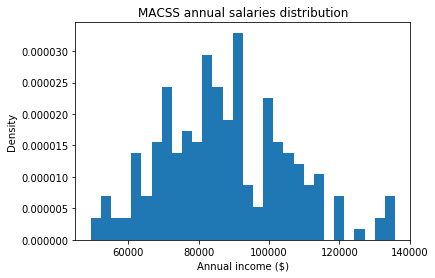

In [3]:
# Plot the histogram 
  
n, bins, patches = plt.hist(income_data, bins=30, density=True)
plt.title("MACSS annual salaries distribution")
plt.xlabel("Annual income ($)")
plt.ylabel("Density")
plt.savefig("pa3_figure_1_hist.png")
plt.show()

In [29]:
# Define functions needed for GMM estimation

def gen_ln_pdf(mu, sigma):
    '''
    Given mu and sigma, returns a lognormal pdf function
    which will calculate the pdf value according to mu and sigma
    
    Returns: pdf function
    '''
    
    def fn(x):
        exponent = ( (np.log(x) - mu)**2 ) /  (-2*(sigma**2)) 
        den = x * sigma * np.sqrt(2*np.pi)
        pdf = np.exp(exponent) / den
        
        return pdf
    
    return fn
 
def data_moments(data):
    '''
    Given a np array of data, returns a tuple 
    of the mean and std. dev
    
    Inputs: (np array) data
    Returns: (tuple) of mean, std. dev
    '''
    mean_data = data.mean()
    std_dev_data = np.sqrt(data.var())
    
    return mean_data, std_dev_data

def model_moments_ln_int(mu, sigma):
    '''
    Given params mu and sigma, calculates the mean and std dev 
    based on a lognormal distribution
    
    Inputs:
        mu: lognormal parameter
        sigma: lognormal parameter
    Returns:
        (tuple) of mean and std. dev of resulting log normal dist
    '''
    ln_pdf = gen_ln_pdf(mu, sigma)
    
    x_fx = lambda x: x * ln_pdf(x)
    mean_model, m_m_err = intgr.quad(x_fx, 0, np.inf)
    
    x2_fx = lambda x: (x**2) * ln_pdf(x)
    eX2_model, v_m_err = intgr.quad(x2_fx, 0, np.inf)
    
    var_model = eX2_model - mean_model**2
    
    return mean_model, np.sqrt(var_model)

def model_moments_ln_anal(mu, sigma):
    '''
    Given params mu and sigma, calculates the mean and std dev 
    based on a lognormal distribution by using the known
    E[X] and Var[X] formulas for a log normal dist. Avoiding the
    integrate command will aid in computation time
    
    Inputs:
        mu: lognormal parameter
        sigma: lognormal parameter
    Returns:
        (tuple) of mean and std. dev of resulting log normal dist
    '''
    exp_x = np.exp(mu+(sigma**2)/2)
    var_x = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
    std_x = np.sqrt(var_x)
    
    return exp_x, std_x

def error_vector(data, mu, sigma, pct_diff=False):
    '''
    Given data and mu,sigma parameters for lognormal distribution,
    returns the error between the observed empirical moments and the 
    moments resulting from the mu,sigma parameter assumptions.
    Note: pct_diff is an optional argument, where True will return
            the % diff, rather than the absolute difference
    
    Inputs:
        data: (np array) of empirical observations
        mu: (float) log normal parameter
        sigma: (float) log normal parameter
        pct_diff: (boolean) True will return % diff
    Returns:
        error_vector (2,1) np matrix
    '''
    
    data_mean, data_std = data_moments(data)
    model_mean, model_std = model_moments_ln_anal(mu, sigma)
    
    data_moms_matrix = np.array([[data_mean], [data_std]])
    model_moms_matrix = np.array([[model_mean], [model_std]])
    
    if pct_diff == True:
        error_vector = (model_moms_matrix - data_moms_matrix) / data_moms_matrix
    else:
        error_vector = (model_moms_matrix - data_moms_matrix)
    
    return error_vector


def criterion_fn(params, *args):
    '''
    Given params (mu and sigma) and args (data and W) 
    returns the weighted squared error
    Inputs: params, args
    
    Returns: crit_val = weighted squared errors under lognormal dist
    '''
    
    mu, sigma = params
    data, W = args
    err = error_vector(data, mu, sigma, pct_diff=True)
    crit_val = err.T @ W @ err
    print("mu={}, sigma={}, crit_val={}".format(mu, sigma, crit_val))
    
    return crit_val

    

## 1b: Estimate parameters using GMM

In [5]:
# Use above functions to find the error miniziming GMM estimate
mu_init = 11
sig_init = .5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income_data,  W_hat)

results = opt.minimize(criterion_fn, params_init, args=(gmm_args), method='L-BFGS-B', bounds=((None, None), (1e-10, None)))


mu=11.0, sigma=0.5, crit_val=[[ 1.06038859]]
mu=11.00000001, sigma=0.5, crit_val=[[ 1.06038862]]
mu=11.0, sigma=0.50000001, crit_val=[[ 1.0603887]]
mu=10.009106675153278, sigma=0.3653507565033885, crit_val=[[ 0.78315727]]
mu=10.009106685153279, sigma=0.3653507565033885, crit_val=[[ 0.78315726]]
mu=10.009106675153278, sigma=0.3653507665033885, crit_val=[[ 0.78315725]]
mu=10.223839534910926, sigma=0.3767935261161933, crit_val=[[ 0.56784422]]
mu=10.223839544910927, sigma=0.3767935261161933, crit_val=[[ 0.56784421]]
mu=10.223839534910926, sigma=0.3767935361161933, crit_val=[[ 0.5678442]]
mu=11.082770973941518, sigma=0.4225646045674126, crit_val=[[ 0.58798198]]
mu=11.082770983941518, sigma=0.4225646045674126, crit_val=[[ 0.587982]]
mu=11.082770973941518, sigma=0.4225646145674126, crit_val=[[ 0.58798205]]
mu=10.688630096375284, sigma=0.4015614694996392, crit_val=[[ 0.21961092]]
mu=10.688630106375285, sigma=0.4015614694996392, crit_val=[[ 0.21961092]]
mu=10.688630096375284, sigma=0.4015614794

In [31]:
# Print results of estimation
mu_GMM1, sig_GMM1 = results.x
params_gmm1 = np.array([mu_GMM1, sig_GMM1])
crit_val = criterion_fn(params_gmm1, *gmm_args)
print()
print("Initial GMM estimates: \nmu={}, sigma={}, crit_val={}".format(mu_GMM1, sig_GMM1, crit_val))


mu=11.359646486963962, sigma=0.20378133845254945, crit_val=[[  4.29550053e-15]]

Initial GMM estimates: 
mu=11.359646486963962, sigma=0.20378133845254945, crit_val=[[  4.29550053e-15]]


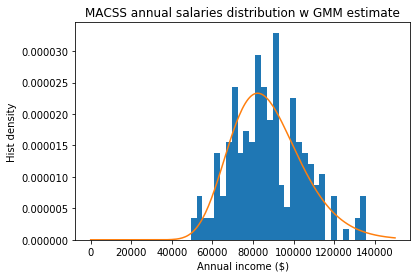

In [32]:
# Plot the initial GMM estimate against the histogram
pdf_ln_gmm1 = gen_ln_pdf(mu_GMM1, sig_GMM1)

n, bins, patches = plt.hist(income_data, bins=30, density=True)
plt.title("MACSS annual salaries distribution w GMM estimate")
plt.xlabel("Annual income ($)")
plt.ylabel("Hist density")
plt.plot(np.linspace(0, 150000, 200), pdf_ln_gmm1(np.linspace(0.1, 150000, 200)))
plt.savefig("pa3_figure_2_histwpdf.png")
plt.show()

In [8]:
# Compare data moments and model moments given estimated parameters
data_expX, data_stdX = data_moments(income_data)
model_expX, model_stdX = model_moments_ln_anal(mu_GMM1, sig_GMM1)
print("E[X] comparison: \n\tdata={}, model={}, difference={}".format(data_expX, model_expX,data_expX - model_expX ))

print("Std Dev[X] comparison: \n\tdata={}, model={}, difference={}".format(data_stdX, model_stdX,data_stdX - model_stdX ))

E[X] comparison: 
	data=87588.93076851241, model=87588.93042380728, difference=0.00034470512764528394
Std Dev[X] comparison: 
	data=18035.906827092327, model=18035.90564715076, difference=0.0011799415660789236


As the extremely low difference in the two moments shows, we are able to find parameters mu,sigma which result in a nearly perfect match with our two moments. This is not necessarily suprising, as given the two equations and two unknowns we can essentially solve for our two parameters, rather than only minimizing the difference

## 1c: Two-step GMM estimator

In [36]:
# Calculate the 2-step optimal wighting matrix
err_gmm1 = error_vector(income_data, mu_GMM1, sig_GMM1, pct_diff=False)
VCV_gmm1 = (1/income_data.shape[0]) * err_gmm1 @ err_gmm1.T
print("Var-cov matrix from err vector GMM estimation:\n", VCV_gmm1)
W_hat_opt = lin.pinv(VCV_gmm1)    # Use pinv because terms are near zero and difficult to invert
print("Optimal weighting matrix: \n", W_hat_opt)

Var-cov matrix from err vector GMM estimation:
 [[  7.74403028e-20   1.28733341e-18]
 [  1.28733341e-18   2.14000624e-17]]
Optimal weighting matrix: 
 [[  1.67880200e+14   2.79076635e+15]
 [  2.79076635e+15   4.63924679e+16]]


As noted above, our model moments are extremely close to the data moments, essentially they are equal. Thus, the inverse of the var-cov matrix is HUGE and I believe this huge matrix results in the issues with the estimation based on the optimal weighting matrix seen below

In [25]:
W_hat_opt

array([[  1.67880200e+14,   2.79076635e+15],
       [  2.79076635e+15,   4.63924679e+16]])

In [26]:
# Do GMM with optimal weighting matrix
mu_init = 11
sig_init = .5
params_init = np.array([mu_init, sig_init])
gmm_args2 = (income_data,  W_hat_opt)

results_opt = opt.minimize(criterion_fn, params_init, args=(gmm_args2), method='L-BFGS-B', bounds=((None, None), (1e-10, None)))


mu=11.0, sigma=0.5, crit_val=[[  4.55814762e+16]]
mu=11.00000001, sigma=0.5, crit_val=[[  4.55814780e+16]]
mu=11.0, sigma=0.50000001, crit_val=[[  4.55814813e+16]]
mu=10.0, sigma=0.5, crit_val=[[  4.32971718e+15]]
mu=10.00000001, sigma=0.5, crit_val=[[  4.32971696e+15]]
mu=10.0, sigma=0.50000001, crit_val=[[  4.32971660e+15]]
mu=10.101835031911548, sigma=0.4999999990652601, crit_val=[[  2.34019785e+15]]
mu=10.10183504191155, sigma=0.4999999990652601, crit_val=[[  2.34019767e+15]]
mu=10.101835031911548, sigma=0.5000000090652601, crit_val=[[  2.34019737e+15]]
mu=10.54749201028984, sigma=0.4999999680427505, crit_val=[[  2.77524392e+15]]
mu=10.547492020289841, sigma=0.4999999680427505, crit_val=[[  2.77524422e+15]]
mu=10.54749201028984, sigma=0.4999999780427505, crit_val=[[  2.77524472e+15]]
mu=10.326101162021464, sigma=0.49999998345393004, crit_val=[[  9.79894416e+12]]
mu=10.326101172021465, sigma=0.49999998345393004, crit_val=[[  9.79893006e+12]]
mu=10.326101162021464, sigma=0.4999999934

In [33]:
# Show results
mu_GMM2, sig_GMM2 = results_opt.x
params_gmm1 = np.array([mu_GMM2, sig_GMM2])
crit_val = criterion_fn(params_gmm1, *gmm_args)
print("GMM results using optimal weighting matrix:\n\tmu={}, sigma={}, crit_val={}".format(mu_GMM2, sig_GMM2, crit_val))


mu=10.339904722603567, sigma=0.49999997136071345, crit_val=[[ 0.36092426]]
GMM results using optimal weighting matrix:
	mu=10.339904722603567, sigma=0.49999997136071345, crit_val=[[ 0.36092426]]


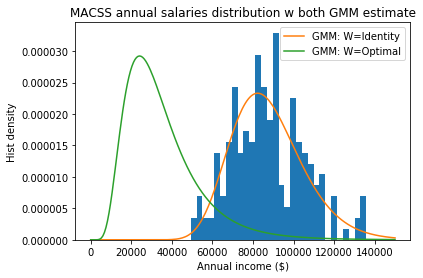

In [34]:
# Plot optimal results along with earlier initial GMM estimations
# Plot
pdf_ln_gmm1 = gen_ln_pdf(mu_GMM1, sig_GMM1)
pdf_ln_gmm2 = gen_ln_pdf(mu_GMM2, sig_GMM2)

n, bins, patches = plt.hist(income_data, bins=30, density=True)
plt.title("MACSS annual salaries distribution w both GMM estimate")
plt.xlabel("Annual income ($)")
plt.ylabel("Hist density")
plt.plot(np.linspace(0, 150000, 200), pdf_ln_gmm1(np.linspace(0.1, 150000, 200)), label="GMM: W=Identity")
plt.plot(np.linspace(0, 150000, 200), pdf_ln_gmm2(np.linspace(0.1, 150000, 200)), label="GMM: W=Optimal")
plt.legend()
plt.savefig("pa3_figure_3_histwoptimal.png")
plt.show()

In [35]:
# Compare data moments and model moments with parameters from optimal weighting matrix estimation
data_expX, data_stdX = data_moments(income_data)
opt_model_expX, opt_model_stdX = model_moments_ln_anal(mu_GMM2, sig_GMM2)
print("E[X] comparison: \n\tdata={}, model={}, difference={}".format(data_expX, opt_model_expX,data_expX - opt_model_expX ))

print("Std Dev[X] comparison: \n\tdata={}, model={}, difference={}".format(data_stdX, opt_model_stdX,data_stdX - opt_model_stdX ))

E[X] comparison: 
	data=87588.93076851241, model=35063.10469375098, difference=52525.826074761426
Std Dev[X] comparison: 
	data=18035.906827092327, model=18686.542078848914, difference=-650.6352517565865


As discussed above, I believe that because our initial fit using W=Identity_Matrix is so close, the inverted var-cov matrix is massive which distorts the resulting criterion function and results in the bizarre fit in the figure above.

## 1d: Estimate GMM using 3 moments based on % in certain brackets

In [54]:
CUTOFF_1 = 75000
CUTOFF_2 = 100000

# Define functions needed for GMM estimation
def data_moments_3(data):
    '''
    Given data and globally defined cutoff values, returns the 
    % of total observations falling into each cutoff bucket.
    
    Inputs: 
        data: np array of data
    
    Returns: (tuple) of pct in each of 3 bins
    '''
    den = data.shape[0]
    assert den > 0, "ERROR: data_moments_3 (divide by 0)"
    
    pct_bin1 = data[data<=CUTOFF_1].shape[0]/den
    pct_bin2 = data[(data>=CUTOFF_1) & (data<=CUTOFF_2)].shape[0]/den
    pct_bin3= data[(data>=CUTOFF_2)].shape[0]/den
    assert np.abs(pct_bin1 + pct_bin2 + pct_bin3 - 1) < 0.00001, "ERROR: data_moments_3 (not equal 100%)"
    
    return pct_bin1, pct_bin2, pct_bin3

def model_moments_3(mu, sigma):
    '''
    Given params mu and sigma, calculates the percent of the CDF in each of
    3 buckets, which are defined globally
    Based on a lognormal distribution
    
    Inputs:
        mu: lognormal parameter
        sigma: lognormal parameter
    
    Returns: (tuple) of pct in each of 3 bins
    '''
    ln_pdf = gen_ln_pdf(mu, sigma)
    
    pct_bin1 = intgr.quad(ln_pdf, 0, CUTOFF_1)[0]
    pct_bin2 = intgr.quad(ln_pdf, CUTOFF_1, CUTOFF_2)[0]
    pct_bin3 = intgr.quad(ln_pdf, CUTOFF_2, np.inf)[0]
    #assert np.abs(pct_bin1 + pct_bin2 + pct_bin3 - 1) < 0.00001, "ERROR: model_moments_3 (not equal 100%)"
        
    return pct_bin1, pct_bin2, pct_bin3

def error_vector_3(data, mu, sigma, pct_diff=False):
    '''
    Given data and mu,sigma parameters for lognormal distribution,
    returns the error between the observed empirical moments and the 
    moments resulting from the mu,sigma parameter assumptions.
    Note: moments here refer to % in each of 3 mutually 
            exhaustive bins, which are defined globally
    
    Note: pct_diff is an optional argument, where True will return
            the % diff, rather than the absolute difference
    
    Inputs:
        data: (np array) of empirical observations
        mu: (float) log normal parameter
        sigma: (float) log normal parameter
        pct_diff: (boolean) True will return % diff
    Returns:
        error_vector (2,1) np matrix
    '''
    
    data_pct_bin1, data_pct_bin2, data_pct_bin3 = data_moments_3(data)
    model_pct_bin1, model_pct_bin2, model_pct_bin3 = model_moments_3(mu, sigma)
    
    data_moms_matrix = np.array([[data_pct_bin1], [data_pct_bin2], [data_pct_bin3]])
    model_moms_matrix = np.array([[model_pct_bin1], [model_pct_bin2], [model_pct_bin3]])
    
    if pct_diff == True:
        error_vector = (model_moms_matrix - data_moms_matrix) / data_moms_matrix
    else:
        error_vector = (model_moms_matrix - data_moms_matrix)
    
    return error_vector


def criterion_fn_3(params, *args):
    '''
    Given params (mu and sigma) and args (data and W) 
    returns the weighted squared error
    Inputs: params, args
    
    Returns: crit_val = weighted squared errors under lognormal dist
    '''
    
    mu, sigma = params
    data, W = args
    err = error_vector_3(data, mu, sigma, pct_diff=True)
    crit_val = err.T @ W @ err
    print("mu={}, sigma={}, crit_val={}".format(mu, sigma, crit_val))
    
    return crit_val


In [55]:
# Check our functions run
data_moments = data_moments_3(income_data)
print("Data moments:" ,data_moments)


Data moments: (0.265, 0.475, 0.26)


In [57]:
# Use above functions to find the error miniziming GMM estimate
mu_init = 11
sig_init = .5
params_init_3 = np.array([mu_init, sig_init])
W_hat_3 = np.eye(3)
gmm_args = (income_data,  W_hat_3)

results_3 = opt.minimize(criterion_fn_3, params_init, args=(gmm_args), method='L-BFGS-B', bounds=((None, None), (1e-10, None)))


mu=11.0, sigma=0.5, crit_val=[[ 2.95334951]]
mu=11.00000001, sigma=0.5, crit_val=[[ 2.9533494]]
mu=11.0, sigma=0.50000001, crit_val=[[ 2.95334946]]
mu=11.90724880629907, sigma=0.9205943455027803, crit_val=[[ 3.06140669]]
mu=11.90724881629907, sigma=0.9205943455027803, crit_val=[[ 3.06140675]]
mu=11.90724880629907, sigma=0.9205943555027803, crit_val=[[ 3.06140667]]
mu=11.350239156662258, sigma=0.6623684791239599, crit_val=[[ 1.07504734]]
mu=11.35023916666226, sigma=0.6623684791239599, crit_val=[[ 1.07504733]]
mu=11.350239156662258, sigma=0.66236848912396, crit_val=[[ 1.07504735]]
mu=11.363271910619655, sigma=0.6114728981255477, crit_val=[[ 0.97646377]]
mu=11.363271920619656, sigma=0.6114728981255477, crit_val=[[ 0.97646377]]
mu=11.363271910619655, sigma=0.6114729081255478, crit_val=[[ 0.97646379]]
mu=11.415402926449243, sigma=0.407890574131899, crit_val=[[ 0.53621127]]
mu=11.415402936449244, sigma=0.407890574131899, crit_val=[[ 0.5362113]]
mu=11.415402926449243, sigma=0.407890584131899,

C:\Users\Cooper\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


mu=11.444165668199709, sigma=0.26977616481883215, crit_val=[[ 0.36336734]]
mu=11.444165658199708, sigma=0.26977617481883215, crit_val=[[ 0.36336727]]
mu=11.41295280560694, sigma=0.13488808245941608, crit_val=[[ 0.69306616]]
mu=11.41295281560694, sigma=0.13488808245941608, crit_val=[[ 0.69306617]]
mu=11.41295280560694, sigma=0.13488809245941608, crit_val=[[ 0.693066]]
mu=11.43263878956097, sigma=0.21996215946104009, crit_val=[[ 0.26177101]]
mu=11.432638799560971, sigma=0.21996215946104009, crit_val=[[ 0.26177109]]
mu=11.43263878956097, sigma=0.21996216946104008, crit_val=[[ 0.261771]]
mu=11.059925217677648, sigma=0.15919823692721513, crit_val=[[ 6.33999276]]
mu=11.059925227677649, sigma=0.15919823692721513, crit_val=[[ 6.33999247]]
mu=11.059925217677648, sigma=0.15919824692721513, crit_val=[[ 6.33999246]]
mu=11.383230029278037, sigma=0.21190699241371735, crit_val=[[ 0.02425857]]
mu=11.383230039278038, sigma=0.21190699241371735, crit_val=[[ 0.02425859]]
mu=11.383230029278037, sigma=0.211

In [60]:
# Print results of estimation using 3 % buckets
mu_GMM3, sig_GMM3 = results_3.x
params_gmm3 = np.array([mu_GMM3, sig_GMM3])
crit_val_3 = criterion_fn_3(params_gmm3, *gmm_args)
print()
print("GMM using 3 % buckets estimates: \nmu={}, sigma={}, crit_val={}".format(mu_GMM3, sig_GMM3, crit_val_3))


mu=11.36734897497453, sigma=0.2262804865970421, crit_val=[[  2.13723830e-13]]

GMM using 3 % buckets estimates: 
mu=11.36734897497453, sigma=0.2262804865970421, crit_val=[[  2.13723830e-13]]


In [61]:
# Compare data moments and model moments given estimated parameters
dm1, dm2, dm3 = data_moments_3(income_data)
mm1, mm2, mm3 = model_moments_3(mu_GMM3, sig_GMM3)
print("% <$75K comparison: \n\tdata={}, model={}, difference={}".format(dm1, mm1,dm1 - mm1 ))
print("% $75K-$100K comparison: \n\tdata={}, model={}, difference={}".format(dm2, mm2,dm2 - mm2 ))
print("% >$100K comparison: \n\tdata={}, model={}, difference={}".format(dm3, mm3,dm3 - mm3 ))


% <$75K comparison: 
	data=0.265, model=0.2649998901002165, difference=1.0989978349584817e-07
% $75K-$100K comparison: 
	data=0.475, model=0.4750000792428613, difference=-7.924286132832137e-08
% >$100K comparison: 
	data=0.26, model=0.26000003065692207, difference=-3.06569220565045e-08


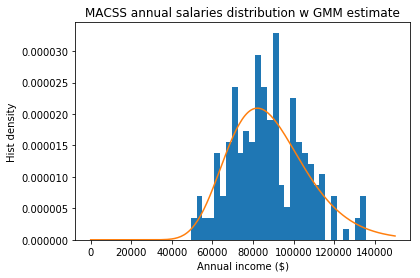

In [62]:
# Plot the 3-part GMM estimate against the histogram
pdf_ln_gmm3 = gen_ln_pdf(mu_GMM3, sig_GMM3)

n, bins, patches = plt.hist(income_data, bins=30, density=True)
plt.title("MACSS annual salaries distribution w GMM estimate")
plt.xlabel("Annual income ($)")
plt.ylabel("Hist density")
plt.plot(np.linspace(0, 150000, 200), pdf_ln_gmm3(np.linspace(0.1, 150000, 200)))
plt.savefig("pa3_figure_3_histwpdf_3pct.png")
plt.show()

## 1e: Two-step estimator on the 3-% estimation

In [63]:
# Calculate the 2-step optimal wighting matrix
err_gmm3 = error_vector_3(income_data, mu_GMM3, sig_GMM3, pct_diff=False)
VCV_gmm3 = (1/income_data.shape[0]) * err_gmm3 @ err_gmm3.T
print("Var-cov matrix from err vector GMM estimation:\n", VCV_gmm3)
W_hat_opt_3 = lin.pinv(VCV_gmm3)    # Use pinv because terms are near zero and difficult to invert
print("Optimal weighting matrix: \n", W_hat_opt_3)

Var-cov matrix from err vector GMM estimation:
 [[  6.03898121e-17  -4.35438665e-17  -1.68459455e-17]
 [ -4.35438665e-17   3.13971554e-17   1.21467111e-17]
 [ -1.68459455e-17   1.21467111e-17   4.69923435e-18]]
Optimal weighting matrix: 
 [[  6.48684106e+15  -4.67731446e+15  -1.80952659e+15]
 [ -4.67731446e+15   3.37256152e+15   1.30475293e+15]
 [ -1.80952659e+15   1.30475293e+15   5.04773658e+14]]


In [66]:
# Do GMM with optimal weighting matrix
mu_init = 11
sig_init = .5
params_init = np.array([mu_init, sig_init])
gmm_args3 = (income_data,  W_hat_opt_3)

results_opt_3 = opt.minimize(criterion_fn_3, params_init, args=(gmm_args3), method='L-BFGS-B', bounds=((None, None), (1e-10, None)))


# Show results
mu_GMM3_opt, sig_GMM3_opt = results_opt_3.x
params_gmm3 = np.array([mu_GMM3_opt, sig_GMM3_opt])
crit_val_3 = criterion_fn_3(params_gmm3, *gmm_args3)
print("GMM results using optimal weighting matrix:\n\tmu={}, sigma={}, crit_val={}".format(mu_GMM3_opt, sig_GMM3_opt, crit_val_3))


mu=11.0, sigma=0.5, crit_val=[[  2.90293927e+16]]
mu=11.00000001, sigma=0.5, crit_val=[[  2.90293917e+16]]
mu=11.0, sigma=0.50000001, crit_val=[[  2.90293923e+16]]
mu=11.922969095813338, sigma=0.8848740679410745, crit_val=[[  3.87205366e+13]]
mu=11.922969105813339, sigma=0.8848740679410745, crit_val=[[  3.87205523e+13]]
mu=11.922969095813338, sigma=0.8848740779410745, crit_val=[[  3.87205236e+13]]
mu=11.908748110622117, sigma=0.8968432527041988, crit_val=[[  1.01522968e+13]]
mu=11.908748120622118, sigma=0.8968432527041988, crit_val=[[  1.01523049e+13]]
mu=11.908748110622117, sigma=0.8968432627041989, crit_val=[[  1.01522903e+13]]
mu=11.89373029275347, sigma=0.9089614036801869, crit_val=[[  2.58487470e+09]]
mu=11.89373030275347, sigma=0.9089614036801869, crit_val=[[  2.58500518e+09]]
mu=11.89373029275347, sigma=0.9089614136801869, crit_val=[[  2.58477410e+09]]
mu=11.89348617163696, sigma=0.9091541526823397, crit_val=[[ 202241.94337082]]
mu=11.89348618163696, sigma=0.9091541526823397, cr

C:\Users\Cooper\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


mu=11.893483990278254, sigma=0.9091558814197194, crit_val=[[ 1.31943134]]
mu=11.89348399027875, sigma=0.9091558714202903, crit_val=[[-0.04215031]]
mu=11.89348400027875, sigma=0.9091558714202903, crit_val=[[ 1.1698544]]
mu=11.89348399027875, sigma=0.9091558814202904, crit_val=[[ 1.31749739]]
mu=11.89348399027875, sigma=0.9091558714202904, crit_val=[[-0.16879902]]
mu=11.89348400027875, sigma=0.9091558714202904, crit_val=[[ 1.10653004]]
mu=11.89348399027875, sigma=0.9091558814202905, crit_val=[[ 1.32142232]]
mu=11.893483988776595, sigma=0.9091558697183764, crit_val=[[-0.09065153]]
mu=11.893483998776595, sigma=0.9091558697183764, crit_val=[[ 1.18516833]]
mu=11.893483988776595, sigma=0.9091558797183764, crit_val=[[ 1.44798586]]
mu=11.893483990023363, sigma=0.9091558711309424, crit_val=[[-0.02755867]]
mu=11.893484000023363, sigma=0.9091558711309424, crit_val=[[ 1.10600074]]
mu=11.893483990023363, sigma=0.9091558811309425, crit_val=[[ 1.40756989]]
mu=11.893483990262784, sigma=0.90915587140220

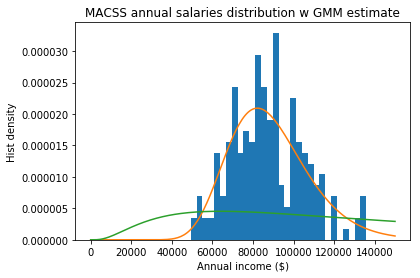

In [67]:
# Plot optimal results along with earlier initial GMM estimations
# Plot
# Plot the 3-part GMM estimate against the histogram
pdf_ln_gmm3 = gen_ln_pdf(mu_GMM3, sig_GMM3)
pdf_ln_gmm3_opt = gen_ln_pdf(mu_GMM3_opt, sig_GMM3_opt)

n, bins, patches = plt.hist(income_data, bins=30, density=True)
plt.title("MACSS annual salaries distribution w GMM estimate")
plt.xlabel("Annual income ($)")
plt.ylabel("Hist density")
plt.plot(np.linspace(0, 150000, 200), pdf_ln_gmm3(np.linspace(0.1, 150000, 200)))
plt.plot(np.linspace(0, 150000, 200), pdf_ln_gmm3_opt(np.linspace(0.1, 150000, 200)))
plt.savefig("pa3_figure_4_histwpdf_3pct.png")
plt.show()

In [68]:
# Compare data moments and model moments given estimated parameters
dm1, dm2, dm3 = data_moments_3(income_data)
mm1_o, mm2_o, mm3_o = model_moments_3(mu_GMM3_opt, sig_GMM3_opt)
print("% <$75K comparison: \n\tdata={}, model={}, difference={}".format(dm1, mm1_o,dm1 - mm1_o ))
print("% $75K-$100K comparison: \n\tdata={}, model={}, difference={}".format(dm2, mm2_o,dm2 - mm2_o ))
print("% >$100K comparison: \n\tdata={}, model={}, difference={}".format(dm3, mm3_o,dm3 - mm3_o ))


% <$75K comparison: 
	data=0.265, model=0.2311660519545324, difference=0.033833948045467604
% $75K-$100K comparison: 
	data=0.475, model=0.10659387002945782, difference=0.3684061299705422
% >$100K comparison: 
	data=0.26, model=0.6622401319919808, difference=-0.40224013199198083


C:\Users\Cooper\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


## 1f: which estimate is the best?

Each estimation fits the data very well, and despite iterative changes the estimates don't change in an economically significant way. For the sake of statistical significance, I would prefer the optimal weigting using the 3-moment approach. I prefer the 3-moment approach because it fits important distributional features of the observed data rather than just a mean and variance. Note: there is an obvious error in my optimal weighting matrix analysis but I'm just moving on

# Part 2

## 2.a

In [71]:
import pandas as pd
df = pd.read_csv(root+"/"+'sick.txt')
df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [91]:
def model_moments_reg(b_0, b_1, b_2, b_3, X_matrix):
    '''
    Given beta assumptions b0-b3, calculates model moments
    
    Inputs:
        b0-b3: coefficient estimates in linear regression
        X_matrix: Pandas DF containing the sick.txt data
    Returns: y_hat estimates
    '''
    
    ones = pd.Series(  np.ones(X_matrix.shape[0])   )  
    
    mod_moms =  b_0*ones + b_1*X_matrix['age'] + b_2*X_matrix['children'] + b_3*X_matrix['avgtemp_winter']
    
    return mod_moms

def err_vec_reg(b_0, b_1, b_2, b_3, X_matrix):
    '''
    Given beta assumptions b0-b3, calculates simple difference 
    between model and observed moments
    
    Inputs:
        b0-b3: coefficient estimates in linear regression
        X_matrix: Pandas DF containing the sick.txt data
    Returns: error vector    
    '''
    
    mod_y_hat = model_moments_reg(b_0, b_1, b_2, b_3, X_matrix)
    error_vec = X_matrix['sick'] - mod_y_hat
    
    return error_vec

def criterion_reg(parameters, data):
    '''
    Computes squared errors
    Inputs:
        params = ([b0, b1, b2, b3])
        data
    
    Returns: crit_val
    '''
    
    b_0, b_1, b_2, b_3 = parameters
    err_vec = err_vec_reg(b_0, b_1, b_2, b_3, data)
    crit_val = np.dot(err_vec, err_vec.T)
    return crit_val



In [92]:
params_init = np.array([0, 0, 0, 0])
results = opt.minimize(criterion_reg, params_init, args = (df) )
b0, b1, b2, b3 = results.x

In [95]:
print("Param estimates for b0-b3 are:\n", b0, b1, b2, b3)

Param estimates for b0-b3 are:
 0.251644302758 0.0129335820436 0.400499865819 -0.00999176007314


In [99]:
print("Value of the criterion function is:\n", criterion_reg((b0, b1, b2, b3), df))

Value of the criterion function is:
 0.00182128968007
